# Place Cell Analysis

Interactive notebook for analyzing place cells in 2D environment navigation.

This notebook runs the full workflow:
1. **Deconvolution** - Extract neural events using OASIS
2. **Event-Place Matching** - Match events to behavior positions
3. **Interactive Visualization** - Browse place cells with scrollable interface

---

**Note:** This notebook uses interactive widgets (progress bars, sliders). When working over SSH, use **Jupyter Lab** instead of VSCode's notebook extension for proper widget support:

```bash
# On remote machine
cd notebook
jupyter lab --no-browser --port=6006

# On local machine - set up SSH tunnel
ssh -L 6006:localhost:6006 user@remote-host

# Then open http://localhost:6006 in your browser
```

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm.notebook import tqdm

from placecell.analysis import (
    compute_coverage_curve,
    compute_coverage_map,
    compute_occupancy_map,
    compute_place_field_mask,
    compute_unit_analysis,
)
from placecell.behavior import build_event_place_dataframe, load_curated_unit_ids
from placecell.config import AppConfig, DataPathsConfig
from placecell.io import load_behavior_data, load_neural_data
from placecell.neural import build_event_index_dataframe, load_traces, run_deconvolution
from placecell.notebook import create_unit_browser
from placecell.visualization import plot_summary_scatter

## Configuration

In [2]:
# Paths - adjust these as needed
CONFIG_PATH = project_root / "placecell/config/example_pcell_config.yaml"
DATA_PATH = Path(
    #"/mnt/data/minizero_analysis/202512round/202511_analysis_placecell/"
    "/Volumes/ProcData/minizero_analysis/202512round/202511_analysis_placecell/"
    "20251201/WL25/WL25_20251201.yaml"
)
DATA_DIR = DATA_PATH.parent
OUTPUT_DIR = project_root / "output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load configs
cfg = AppConfig.from_yaml(CONFIG_PATH)
data_cfg = DataPathsConfig.from_yaml(DATA_PATH)

# Apply data-specific overrides (e.g., OASIS parameters)
cfg = cfg.with_data_overrides(data_cfg)

# Resolve data paths relative to data directory
neural_path = DATA_DIR / data_cfg.neural_path
neural_timestamp = DATA_DIR / data_cfg.neural_timestamp
behavior_position = DATA_DIR / data_cfg.behavior_position
behavior_timestamp = DATA_DIR / data_cfg.behavior_timestamp
curation_csv = (DATA_DIR / data_cfg.curation_csv) if data_cfg.curation_csv else None

print(f"Config: {CONFIG_PATH}")
print(f"Data: {DATA_PATH}")
print(f"Neural path: {neural_path}")
print(f"Neural timestamp: {neural_timestamp}")
print(f"Behavior position: {behavior_position}")
print(f"Behavior timestamp: {behavior_timestamp}")
print(f"Curation CSV: {curation_csv}")

Config: /Users/takuya/Git/placecell/placecell/config/example_pcell_config.yaml
Data: /Volumes/ProcData/minizero_analysis/202512round/202511_analysis_placecell/20251201/WL25/WL25_20251201.yaml
Neural path: /Volumes/ProcData/minizero_analysis/202512round/202511_analysis_placecell/20251201/WL25/neural_proc/minian
Neural timestamp: /Volumes/ProcData/minizero_analysis/202512round/202511_analysis_placecell/20251201/WL25/neural_proc/WL25_20251201.csv
Behavior position: /Volumes/ProcData/minizero_analysis/202512round/202511_analysis_placecell/20251201/WL25/behav_proc/DLC_1764635139.csv
Behavior timestamp: /Volumes/ProcData/minizero_analysis/202512round/202511_analysis_placecell/20251201/WL25/behav_proc/1764635139.csv
Curation CSV: None


In [3]:
# Extract config values
bodypart = cfg.behavior.bodypart
behavior_fps = cfg.behavior.behavior_fps
speed_threshold = cfg.behavior.speed_threshold
speed_window_frames = cfg.behavior.speed_window_frames
bins = cfg.behavior.spatial_map.bins
min_occupancy = cfg.behavior.spatial_map.min_occupancy
occupancy_sigma = cfg.behavior.spatial_map.occupancy_sigma
activity_sigma = cfg.behavior.spatial_map.activity_sigma
n_shuffles = cfg.behavior.spatial_map.n_shuffles
random_seed = cfg.behavior.spatial_map.random_seed
event_threshold_sigma = cfg.behavior.spatial_map.event_threshold_sigma
p_value_threshold = cfg.behavior.spatial_map.p_value_threshold
stability_threshold = cfg.behavior.spatial_map.stability_threshold
stability_method = cfg.behavior.spatial_map.stability_method
min_shift_seconds = cfg.behavior.spatial_map.min_shift_seconds
si_weight_mode = cfg.behavior.spatial_map.si_weight_mode
place_field_threshold = cfg.behavior.spatial_map.place_field_threshold
place_field_min_bins = cfg.behavior.spatial_map.place_field_min_bins
place_field_seed_percentile = cfg.behavior.spatial_map.place_field_seed_percentile

# Neural config
trace_name = cfg.neural.trace_name
neural_fps = cfg.neural.fps
max_units = cfg.neural.max_units
g = cfg.neural.oasis.g
baseline = cfg.neural.oasis.baseline
penalty = cfg.neural.oasis.penalty
s_min = cfg.neural.oasis.s_min

# Visualization settings
trace_time_window = 600.0  # 10 minutes window for trace display

print(f"Bodypart: {bodypart}")
print(f"Speed threshold: {speed_threshold} px/s")
print(f"Bins: {bins}")
print(f"Shuffles: {n_shuffles}")
print(f"Min shift: {min_shift_seconds}s")
print(f"SI weight mode: {si_weight_mode}")
print(f"Stability method: {stability_method}")
print(f"Place field threshold: {place_field_threshold}")
print(f"Place field min bins: {place_field_min_bins}")
print(f"Place field seed percentile: {place_field_seed_percentile}")
print(f"Trace name: {trace_name}")
print(f"OASIS g: {g}")

Bodypart: LED_clean
Speed threshold: 10.0 px/s
Bins: 50
Shuffles: 500
Min shift: 20.0s
SI weight mode: amplitude
Stability method: threshold
Place field threshold: 0.2
Place field min bins: 5
Place field seed percentile: 95.0
Trace name: C_lp
OASIS g: (1.3805576774138437, -0.4111122905071874)


## Unit Subset (for quick iteration)

Set `UNIT_IDS` to a list of specific unit IDs to process only those units.
Set to `None` to process all units.

In [4]:
# Set to a list of unit IDs for quick iteration, e.g. [0, 5, 42]
# Set to None to process all units
UNIT_IDS = None
#UNIT_IDS = [1, 2, 3, 4, 5]

## Step 1: Deconvolution

Run OASIS deconvolution to extract neural events from calcium traces.

In [5]:
# Load traces
print(f"Loading traces from: {neural_path / (trace_name + '.zarr')}")
C_da = load_traces(neural_path, trace_name=trace_name)
all_unit_ids = list(map(int, C_da["unit_id"].values))
print(f"Total units in traces: {len(all_unit_ids)}")

# Filter by curation CSV if provided
if curation_csv is not None and curation_csv.exists():
    curated_ids = set(load_curated_unit_ids(curation_csv))
    all_unit_ids = [uid for uid in all_unit_ids if uid in curated_ids]
    print(f"After curation filter: {len(all_unit_ids)} units")

# Apply unit subset
if UNIT_IDS is not None:
    available = set(all_unit_ids)
    all_unit_ids = [uid for uid in UNIT_IDS if uid in available]
    missing = set(UNIT_IDS) - available
    if missing:
        print(f"Warning: requested unit IDs not found: {sorted(missing)}")
    print(f"Selected {len(all_unit_ids)} specific units: {all_unit_ids}")
elif max_units is not None and len(all_unit_ids) > max_units:
    all_unit_ids = all_unit_ids[:max_units]
    print(f"Limited to first {max_units} units (from config)")

print(f"Will process {len(all_unit_ids)} units")

# Run OASIS deconvolution
print(f"Running OASIS deconvolution (g={g})...")

good_unit_ids, C_list, S_list = run_deconvolution(
    C_da=C_da,
    unit_ids=all_unit_ids,
    g=g,
    baseline=baseline,
    penalty=penalty,
    s_min=s_min,
    progress_bar=lambda x: tqdm(x, desc="Deconvolving units"),
)

print(f"Successfully deconvolved {len(good_unit_ids)} units")

Loading traces from: /Volumes/ProcData/minizero_analysis/202512round/202511_analysis_placecell/20251201/WL25/neural_proc/minian/C_lp.zarr
Total units in traces: 204
Will process 204 units
Running OASIS deconvolution (g=(1.3805576774138437, -0.4111122905071874))...


/Users/takuya/Git/placecell/.venv/lib/python3.11/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


Deconvolving units:   0%|          | 0/204 [00:00<?, ?it/s]

Successfully deconvolved 204 units


In [6]:
# Build event index from deconvolution results
event_index_df = build_event_index_dataframe(good_unit_ids, S_list)
event_index_csv = OUTPUT_DIR / "event_index_notebook.csv"
event_index_df.to_csv(event_index_csv, index=False)
print(f"Event index: {len(event_index_df)} events from {event_index_df['unit_id'].nunique()} units")
print(f"Saved to: {event_index_csv}")

Event index: 4550375 events from 204 units
Saved to: /Users/takuya/Git/placecell/output/event_index_notebook.csv


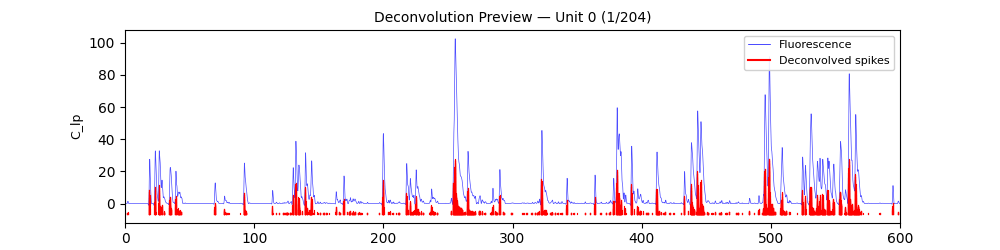

In [7]:
%matplotlib widget
import ipywidgets as widgets
from matplotlib.lines import Line2D

# Interactive deconvolution preview
fig_deconv, ax_deconv = plt.subplots(1, 1, figsize=(10, 2.5))
fig_deconv.canvas.toolbar_visible = False
fig_deconv.canvas.header_visible = False
fig_deconv.canvas.layout.width = "100%"

n_good = len(good_unit_ids)
_deconv_time_window = 600.0  # 10 min window
_deconv_max_time = C_da.sizes["frame"] / neural_fps


def _render_deconv(unit_idx, t_start):
    ax_deconv.clear()
    uid = good_unit_ids[unit_idx]
    trace = C_da.sel(unit_id=uid).values
    t_full = np.arange(len(trace)) / neural_fps
    spikes = S_list[unit_idx]

    t_end = min(_deconv_max_time, t_start + _deconv_time_window)
    mask = (t_full >= t_start) & (t_full <= t_end)

    ax_deconv.plot(t_full[mask], trace[mask], "b-", linewidth=0.5, alpha=0.7)

    # Spike stems in time window
    spike_frames = np.nonzero(spikes > 0)[0]
    spike_times = spike_frames / neural_fps
    spike_mask = (spike_times >= t_start) & (spike_times <= t_end)
    if np.any(spike_mask):
        st = spike_times[spike_mask]
        sa = spikes[spike_frames[spike_mask]]
        y_min, y_max = ax_deconv.get_ylim()
        amp_max = sa.max() if sa.max() > 0 else 1.0
        max_spike_h = (y_max - y_min) * 0.3
        for t_s, a_s in zip(st, sa):
            h = (a_s / amp_max) * max_spike_h
            ax_deconv.plot([t_s, t_s], [y_min, y_min + h], color="red", lw=0.8)

    ax_deconv.set_xlim(t_start, t_end)
    ax_deconv.set_ylabel(trace_name, fontsize=9)
    ax_deconv.set_xlabel("Time (s)", fontsize=9)
    ax_deconv.set_title(
        f"Deconvolution Preview — Unit {uid} ({unit_idx + 1}/{n_good})",
        fontsize=10,
    )
    ax_deconv.legend(
        handles=[
            Line2D([0], [0], color="blue", linewidth=0.5, label="Fluorescence"),
            Line2D([0], [0], color="red", linewidth=1.5, label="Deconvolved spikes"),
        ],
        loc="upper right",
        fontsize=8,
        framealpha=0.9,
    )
    fig_deconv.canvas.draw_idle()


# Widgets
_unit_slider_d = widgets.IntSlider(
    value=0, min=0, max=n_good - 1, step=1,
    description="Unit:", continuous_update=False,
    layout=widgets.Layout(width="100%"),
)
_time_slider_d = widgets.FloatSlider(
    value=0, min=0, max=max(0, _deconv_max_time - _deconv_time_window),
    step=10, description="Time (s):", continuous_update=False,
    layout=widgets.Layout(width="100%"),
)
_prev_btn_d = widgets.Button(description="< Prev", layout=widgets.Layout(width="70px"))
_next_btn_d = widgets.Button(description="Next >", layout=widgets.Layout(width="70px"))


def _on_prev_d(_):
    _unit_slider_d.value = (_unit_slider_d.value - 1) % n_good


def _on_next_d(_):
    _unit_slider_d.value = (_unit_slider_d.value + 1) % n_good


_prev_btn_d.on_click(_on_prev_d)
_next_btn_d.on_click(_on_next_d)


def _update_deconv(_=None):
    _render_deconv(_unit_slider_d.value, _time_slider_d.value)


_unit_slider_d.observe(_update_deconv, names="value")
_time_slider_d.observe(_update_deconv, names="value")

_nav_d = widgets.HBox(
    [_prev_btn_d, _unit_slider_d, _next_btn_d],
    layout=widgets.Layout(width="100%"),
)
_controls_d = widgets.VBox([_nav_d, _time_slider_d], layout=widgets.Layout(width="100%"))

_render_deconv(0, 0)
plt.show()
display(_controls_d)

## Step 2: Event-Place Matching

Match neural events to behavior positions.

In [8]:
# Build event-place dataframe
print("Matching events to behavior positions...")

event_place_df = build_event_place_dataframe(
    event_index_path=event_index_csv,
    neural_timestamp_path=neural_timestamp,
    behavior_position_path=behavior_position,
    behavior_timestamp_path=behavior_timestamp,
    bodypart=bodypart,
    behavior_fps=behavior_fps,
    speed_threshold=speed_threshold,
    speed_window_frames=speed_window_frames,
)

print(f"Event-place entries: {len(event_place_df)}")
print(f"Unique units: {event_place_df['unit_id'].nunique()}")

# Save event-place (optional)
event_place_csv = OUTPUT_DIR / "event_place_notebook.csv"
event_place_df.to_csv(event_place_csv, index=False)
print(f"Saved event-place to: {event_place_csv}")

Matching events to behavior positions...
Event-place entries: 1503242
Unique units: 204
Saved event-place to: /Users/takuya/Git/placecell/output/event_place_notebook.csv


## Step 3: Analysis & Visualization

Compute spatial tuning metrics (rate maps, spatial information, stability) and visualize results.

In [9]:
# Filter by speed threshold
df_filtered = event_place_df[event_place_df["speed"] >= speed_threshold].copy()
df_all_events = event_index_df.copy()

print(f"Speed-filtered events: {len(df_filtered)}")
print(f"Unique units after filtering: {df_filtered['unit_id'].nunique()}")

Speed-filtered events: 1503242
Unique units after filtering: 204


In [10]:
# Load behavior data
trajectory_with_speed, trajectory_df = load_behavior_data(
    behavior_position=behavior_position,
    behavior_timestamp=behavior_timestamp,
    bodypart=bodypart,
    speed_window_frames=speed_window_frames,
    speed_threshold=speed_threshold,
)

print(f"Trajectory frames: {len(trajectory_df)}")

Trajectory frames: 32663


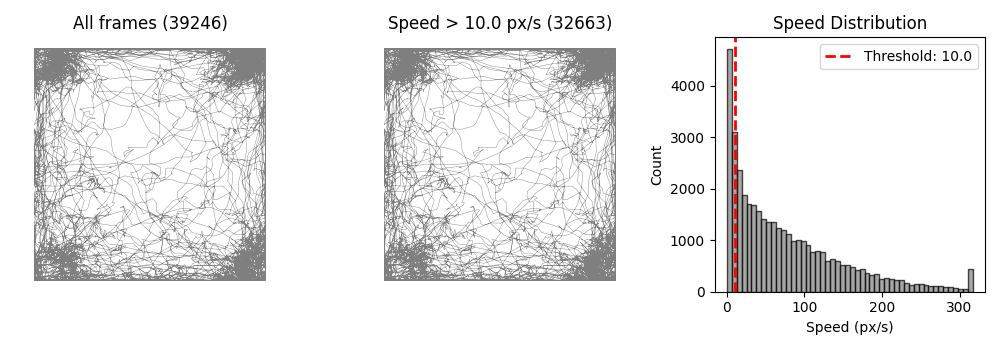

In [11]:
# Preview: behavior data (raw vs filtered trajectory + speed histogram)
fig_beh, (ax_raw, ax_filt, ax_hist) = plt.subplots(1, 3, figsize=(10, 3.5))

# Raw trajectory (all speeds)
ax_raw.plot(trajectory_with_speed["x"], trajectory_with_speed["y"],
            "k-", linewidth=0.3, alpha=0.5)
ax_raw.set_title(f"All frames ({len(trajectory_with_speed)})")
ax_raw.set_aspect("equal")
ax_raw.axis("off")

# Speed-filtered trajectory
ax_filt.plot(trajectory_df["x"], trajectory_df["y"],
             "k-", linewidth=0.3, alpha=0.5)
ax_filt.set_title(f"Speed > {speed_threshold} px/s ({len(trajectory_df)})")
ax_filt.set_aspect("equal")
ax_filt.axis("off")

# Speed histogram
all_speeds = trajectory_with_speed["speed"].dropna()
speed_max = np.percentile(all_speeds, 99)
ax_hist.hist(all_speeds.clip(upper=speed_max), bins=50,
             color="gray", edgecolor="black", alpha=0.7)
ax_hist.axvline(speed_threshold, color="red", linestyle="--", linewidth=2,
                label=f"Threshold: {speed_threshold}")
ax_hist.set_xlabel("Speed (px/s)")
ax_hist.set_ylabel("Count")
ax_hist.set_title("Speed Distribution")
ax_hist.legend()

fig_beh.tight_layout()
plt.show()

In [12]:
# Compute occupancy map
occupancy_time, valid_mask, x_edges, y_edges = compute_occupancy_map(
    trajectory_df=trajectory_df,
    bins=bins,
    behavior_fps=behavior_fps,
    occupancy_sigma=occupancy_sigma,
    min_occupancy=min_occupancy,
)

print(f"Occupancy map shape: {occupancy_time.shape}")
print(f"Valid bins: {valid_mask.sum()} / {valid_mask.size}")

Occupancy map shape: (50, 50)
Valid bins: 2092 / 2500


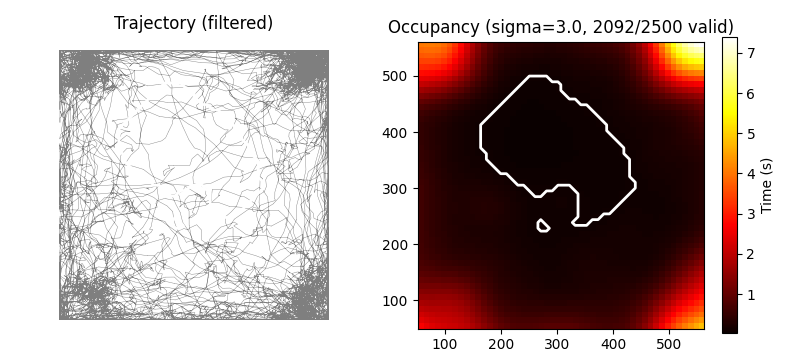

In [13]:
# Preview: occupancy map with trajectory
fig_occ, (ax_traj, ax_occ) = plt.subplots(1, 2, figsize=(8, 3.5))

ext = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

# Trajectory with valid-bin contour
ax_traj.plot(trajectory_df["x"], trajectory_df["y"],
             "k-", alpha=0.5, linewidth=0.3)
if np.any(valid_mask) and not np.all(valid_mask):
    ax_traj.contour(
        valid_mask.T.astype(float), levels=[0.5],
        colors="white", linewidths=2,
        extent=ext, origin="lower",
    )
ax_traj.set_title("Trajectory (filtered)")
ax_traj.set_aspect("equal")
ax_traj.axis("off")

# Occupancy heatmap with valid-bin contour
im = ax_occ.imshow(
    occupancy_time.T, origin="lower", extent=ext,
    cmap="hot", aspect="equal",
)
if np.any(valid_mask) and not np.all(valid_mask):
    ax_occ.contour(
        valid_mask.T.astype(float), levels=[0.5],
        colors="white", linewidths=2,
        extent=ext, origin="lower",
    )
ax_occ.set_title(f"Occupancy (sigma={occupancy_sigma}, {valid_mask.sum()}/{valid_mask.size} valid)")
plt.colorbar(im, ax=ax_occ, label="Time (s)")

fig_occ.tight_layout()
plt.show()

In [14]:
# Load neural data (for visualization)
traces, max_proj, footprints = load_neural_data(
    neural_path=neural_path,
    trace_name=trace_name,
)

print(f"Traces shape: {traces.shape if traces is not None else 'None'}")
print(f"Max proj shape: {max_proj.shape if max_proj is not None else 'None'}")
print(f"Footprints shape: {footprints.shape if footprints is not None else 'None'}")

Traces shape: (204, 39541)
Max proj shape: (200, 200)
Footprints shape: (204, 200, 200)


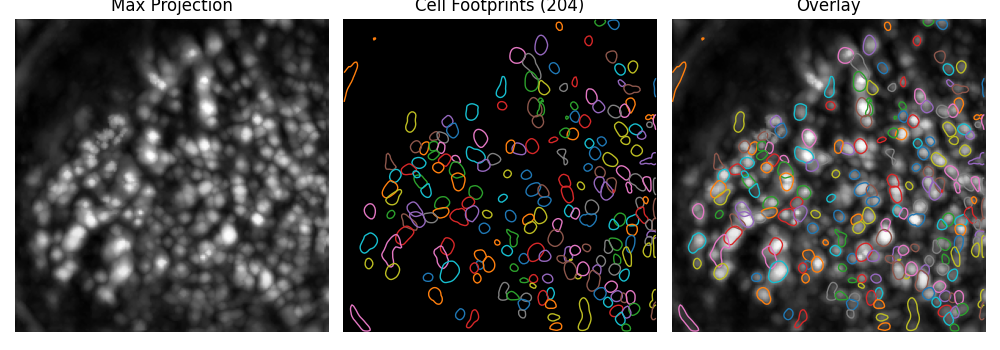

In [15]:
# Plot max projection, cell footprints, and overlay
if max_proj is not None and footprints is not None:
    fig_fp, (ax_mp, ax_fp, ax_ov) = plt.subplots(1, 3, figsize=(10, 3.5))

    unit_ids_fp = footprints.coords["unit_id"].values
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # Left: max projection
    ax_mp.imshow(max_proj, cmap="gray", aspect="equal")
    ax_mp.set_title("Max Projection")
    ax_mp.axis("off")

    # Middle: colored footprint contours on black background
    ax_fp.imshow(np.zeros_like(max_proj), cmap="gray", aspect="equal")
    for i, uid in enumerate(unit_ids_fp):
        fp = footprints.sel(unit_id=uid).values
        if fp.max() > 0:
            ax_fp.contour(fp, levels=[fp.max() * 0.3], colors=[colors[i % len(colors)]], linewidths=1)
    ax_fp.set_title(f"Cell Footprints ({len(unit_ids_fp)})")
    ax_fp.axis("off")

    # Right: overlay
    ax_ov.imshow(max_proj, cmap="gray", aspect="equal")
    for i, uid in enumerate(unit_ids_fp):
        fp = footprints.sel(unit_id=uid).values
        if fp.max() > 0:
            ax_ov.contour(fp, levels=[fp.max() * 0.3], colors=[colors[i % len(colors)]], linewidths=1)
    ax_ov.set_title("Overlay")
    ax_ov.axis("off")

    fig_fp.tight_layout()
    plt.show()
else:
    print("Max projection or footprints not available, skipping plot.")

In [16]:
# Set random seed
if random_seed is not None:
    np.random.seed(random_seed)

# Compute analysis for each unit (limited to the deconvolved units)
unique_units = sorted(df_filtered["unit_id"].unique())
unique_units = [uid for uid in unique_units if uid in good_unit_ids]
n_units = len(unique_units)
print(f"Computing analysis for {n_units} units...")

unit_results = {}
for unit_id in tqdm(unique_units, desc="Computing unit analysis"):
    result = compute_unit_analysis(
        unit_id=unit_id,
        df_filtered=df_filtered,
        trajectory_df=trajectory_df,
        occupancy_time=occupancy_time,
        valid_mask=valid_mask,
        x_edges=x_edges,
        y_edges=y_edges,
        activity_sigma=activity_sigma,
        event_threshold_sigma=event_threshold_sigma,
        n_shuffles=n_shuffles,
        behavior_fps=behavior_fps,
        min_occupancy=min_occupancy,
        occupancy_sigma=occupancy_sigma,
        stability_threshold=stability_threshold,
        stability_method=stability_method,
        min_shift_seconds=min_shift_seconds,
        si_weight_mode=si_weight_mode,
        place_field_seed_percentile=place_field_seed_percentile,
    )

    # Visualization data
    vis_data_above = result["events_above_threshold"]
    vis_data_below = pd.DataFrame()
    if df_all_events is not None:
        unit_all_events = df_all_events[df_all_events["unit_id"] == unit_id]
        vis_data_below = unit_all_events[unit_all_events["s"] > result["vis_threshold"]]

    # Trace data
    trace_data = None
    trace_times = None
    if traces is not None:
        try:
            trace_data = traces.sel(unit_id=int(unit_id)).values
            trace_times = np.arange(len(trace_data)) / neural_fps
        except (KeyError, IndexError):
            pass

    unit_results[unit_id] = {
        "rate_map": result["rate_map"],
        "rate_map_raw": result["rate_map_raw"],
        "si": result["si"],
        "shuffled_sis": result["shuffled_sis"],
        "shuffled_rate_p95": result["shuffled_rate_p95"],
        "p_val": result["p_val"],
        "stability_corr": result["stability_corr"],
        "stability_z": result["stability_z"],
        "stability_p_val": result["stability_p_val"],
        "rate_map_first": result["rate_map_first"],
        "rate_map_second": result["rate_map_second"],
        "vis_data_above": vis_data_above,
        "vis_data_below": vis_data_below,
        "unit_data": result["unit_data"],
        "trace_data": trace_data,
        "trace_times": trace_times,
    }

print(f"Done. Computed analysis for {len(unit_results)} units.")

Computing analysis for 204 units...


Computing unit analysis:   0%|          | 0/204 [00:00<?, ?it/s]

Done. Computed analysis for 204 units.


## Summary Scatter Plot

## Diagnostics

Event count distribution and its relationship to SI and significance.

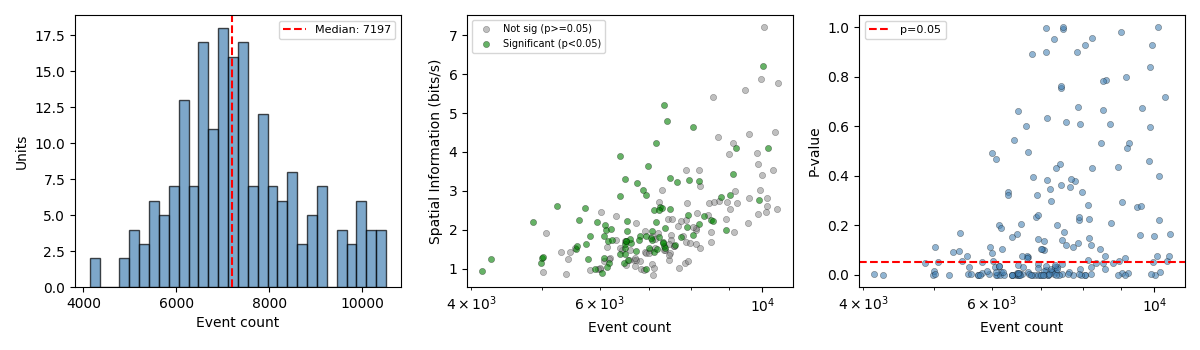

Total units: 204
Significant (p<0.05): 93 (45.6%)
Event count: median=7197, min=4139, max=10513


In [17]:
# Diagnostic plots: event counts, SI vs events, p-value vs events
_uids = list(unit_results.keys())
_n_events = [len(unit_results[u]["unit_data"]) for u in _uids]
_si_vals = [unit_results[u]["si"] for u in _uids]
_p_vals = [unit_results[u]["p_val"] for u in _uids]
_p_thresh = p_value_threshold or 0.05

fig_diag, (ax_hist, ax_si, ax_pv) = plt.subplots(1, 3, figsize=(12, 3.5))

# 1. Event count histogram
ax_hist.hist(_n_events, bins=30, color="steelblue", edgecolor="black", alpha=0.7)
ax_hist.set_xlabel("Event count")
ax_hist.set_ylabel("Units")
ax_hist.axvline(np.median(_n_events), color="red", linestyle="--", lw=1.5,
                label=f"Median: {int(np.median(_n_events))}")
ax_hist.legend(fontsize=8)

# 2. SI vs event count
_sig_mask = [p < _p_thresh for p in _p_vals]
_ns_mask = [not m for m in _sig_mask]
_n_ev = np.array(_n_events)
_si = np.array(_si_vals)
ax_si.scatter(_n_ev[_ns_mask], _si[_ns_mask], c="gray", s=20, alpha=0.5,
              edgecolors="black", linewidths=0.3, label=f"Not sig (p>={_p_thresh})")
ax_si.scatter(_n_ev[_sig_mask], _si[_sig_mask], c="green", s=20, alpha=0.6,
              edgecolors="black", linewidths=0.3, label=f"Significant (p<{_p_thresh})")
ax_si.set_xlabel("Event count")
ax_si.set_ylabel("Spatial Information (bits/s)")
ax_si.set_xscale("log")
ax_si.legend(fontsize=7)

# 3. P-value vs event count
ax_pv.scatter(_n_events, _p_vals, c="steelblue", s=20, alpha=0.6, edgecolors="black", linewidths=0.3)
ax_pv.axhline(_p_thresh, color="red", linestyle="--", lw=1.5, label=f"p={_p_thresh}")
ax_pv.set_xlabel("Event count")
ax_pv.set_ylabel("P-value")
ax_pv.set_xscale("log")
ax_pv.legend(fontsize=8)

fig_diag.tight_layout()
plt.show()

# Print summary
_n_sig = sum(_sig_mask)
print(f"Total units: {len(_uids)}")
print(f"Significant (p<{_p_thresh}): {_n_sig} ({100*_n_sig/len(_uids):.1f}%)")
print(f"Event count: median={int(np.median(_n_events))}, min={min(_n_events)}, max={max(_n_events)}")

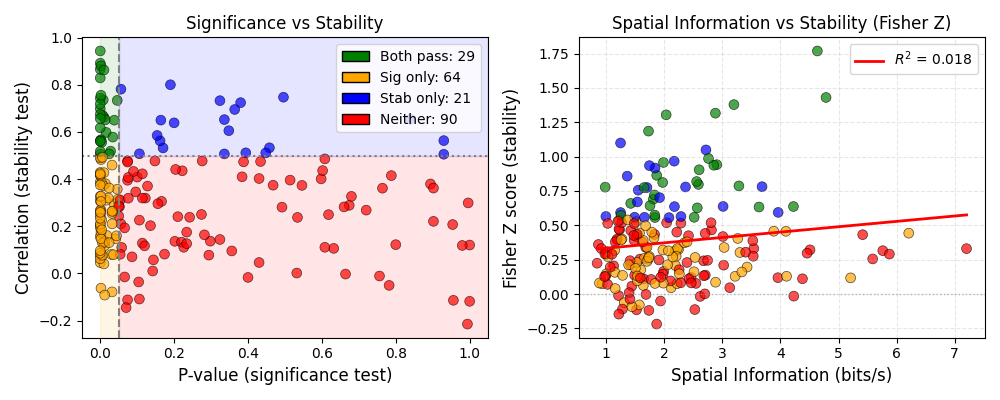

In [18]:
plot_summary_scatter(
    unit_results=unit_results,
    p_value_threshold=p_value_threshold,
    stability_threshold=stability_threshold,
)
plt.show()

## Place Field Coverage

Combined place field coverage map and cumulative coverage curve (cf. Guo et al. 2023, Fig. 4H-I).
Red contours on rate maps show the place field boundary at a given threshold of peak rate.

Significant cells: 93 / 204
Place cells (sig + stable): 29 / 204
Place field threshold: 0.2, min bins: 5


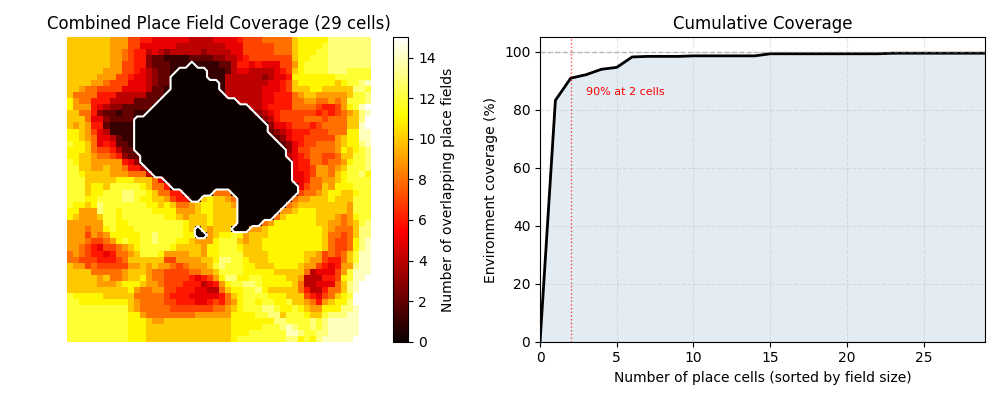

Valid bins: 2092
Covered bins: 2082 (99.5%)
Max overlap: 15 fields at a single bin
Mean overlap (covered bins): 9.1


In [19]:
# Place field coverage analysis (Guo et al. 2023, Fig. 4H-I)
# place_field_threshold and place_field_min_bins are loaded from config in cell-4

# Filter to cells that pass BOTH significance AND stability tests
_p_thresh = p_value_threshold or 0.05

def _is_place_cell(res):
    """Check if a unit passes both significance and stability tests."""
    sig_pass = res["p_val"] < _p_thresh
    stab_corr = res.get("stability_corr", np.nan)
    stab_p = res.get("stability_p_val", np.nan)
    if np.isnan(stab_corr):
        stab_pass = False
    elif not np.isnan(stab_p):
        stab_pass = stab_p < _p_thresh
    else:
        stab_pass = stab_corr >= stability_threshold
    return sig_pass and stab_pass

place_cell_results = {
    uid: res for uid, res in unit_results.items()
    if _is_place_cell(res)
}
n_place_cells = len(place_cell_results)
n_sig_only = sum(1 for res in unit_results.values() if res["p_val"] < _p_thresh)
print(f"Significant cells: {n_sig_only} / {len(unit_results)}")
print(f"Place cells (sig + stable): {n_place_cells} / {len(unit_results)}")
print(f"Place field threshold: {place_field_threshold}, min bins: {place_field_min_bins}")

# Compute coverage map and curve
coverage_map = compute_coverage_map(
    place_cell_results, threshold=place_field_threshold, min_bins=place_field_min_bins,
)
n_cells_arr, coverage_frac = compute_coverage_curve(
    place_cell_results, valid_mask,
    threshold=place_field_threshold, min_bins=place_field_min_bins,
)

ext = [x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]]

fig_cov, (ax_map, ax_curve) = plt.subplots(1, 2, figsize=(10, 4))

# Left: coverage heatmap (Fig 4H)
im = ax_map.imshow(
    coverage_map.T, origin="lower", extent=ext,
    cmap="hot", aspect="equal",
)
# Contour at the boundary of any coverage
if np.any(coverage_map > 0):
    ax_map.contour(
        (coverage_map > 0).T.astype(float), levels=[0.5],
        colors="white", linewidths=1.5,
        extent=ext, origin="lower",
    )
plt.colorbar(im, ax=ax_map, label="Number of overlapping place fields")
ax_map.set_title(f"Combined Place Field Coverage ({n_place_cells} cells)")
ax_map.axis("off")

# Right: cumulative coverage curve (Fig 4I)
ax_curve.plot(n_cells_arr, coverage_frac * 100, "k-", linewidth=2)
ax_curve.fill_between(n_cells_arr, 0, coverage_frac * 100, alpha=0.15, color="steelblue")
ax_curve.set_xlabel("Number of place cells (sorted by field size)")
ax_curve.set_ylabel("Environment coverage (%)")
ax_curve.set_title("Cumulative Coverage")
ax_curve.set_ylim(0, 105)
ax_curve.set_xlim(0, n_place_cells)
ax_curve.axhline(100, color="gray", linestyle="--", linewidth=1, alpha=0.5)
ax_curve.grid(True, alpha=0.3, linestyle="--")

# Mark 90% and 100% coverage thresholds
for pct in [90, 100]:
    idx = np.searchsorted(coverage_frac, pct / 100.0)
    if idx < len(n_cells_arr):
        ax_curve.axvline(n_cells_arr[idx], color="red", linestyle=":", linewidth=1, alpha=0.7)
        ax_curve.text(
            n_cells_arr[idx] + 1, pct - 5,
            f"{pct}% at {n_cells_arr[idx]} cells",
            fontsize=8, color="red",
        )

fig_cov.tight_layout()
plt.show()

# Print coverage statistics
n_valid = int(valid_mask.sum())
n_covered = int(np.sum((coverage_map > 0) & valid_mask))
print(f"Valid bins: {n_valid}")
print(f"Covered bins: {n_covered} ({100 * n_covered / n_valid:.1f}%)")
print(f"Max overlap: {coverage_map.max()} fields at a single bin")
if np.any(coverage_map > 0):
    print(f"Mean overlap (covered bins): {coverage_map[coverage_map > 0].mean():.1f}")

## Interactive Cell Browser

Use the slider to scroll through cells. Use the time slider to scroll through the trace.

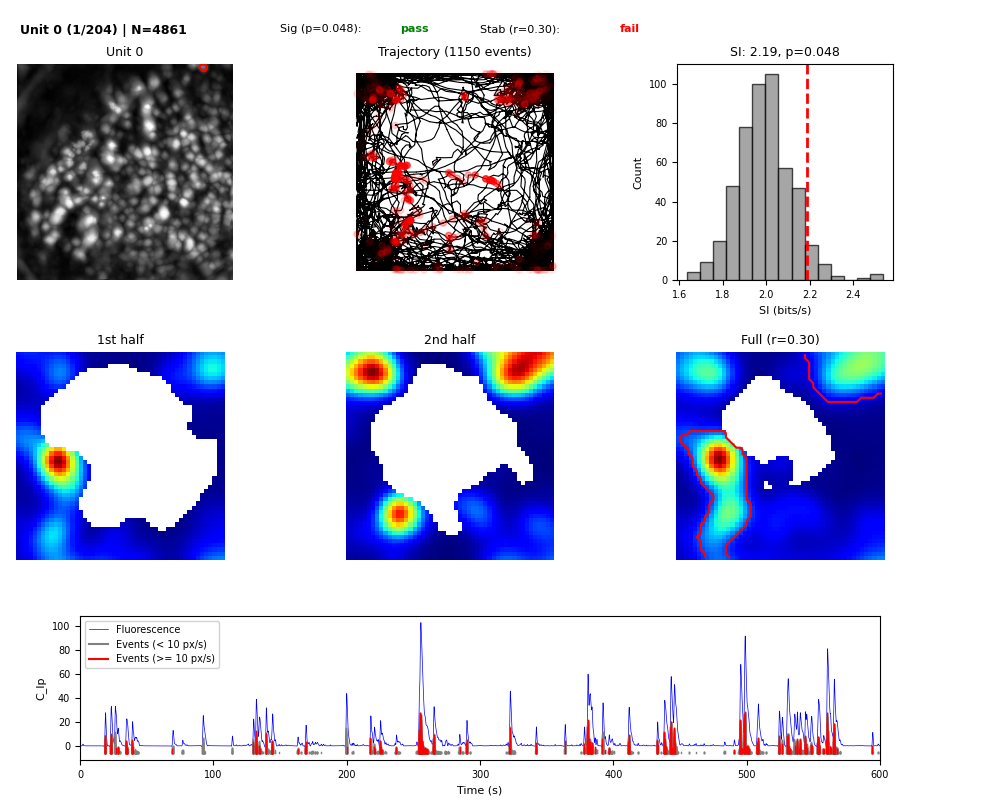

In [20]:
%matplotlib widget

fig, controls = create_unit_browser(
    unit_results=unit_results,
    unique_units=unique_units,
    trajectory_df=trajectory_df,
    df_all_events=df_all_events,
    max_proj=max_proj,
    footprints=footprints,
    x_edges=x_edges,
    y_edges=y_edges,
    occupancy_time=occupancy_time,
    trace_name=trace_name,
    neural_fps=neural_fps,
    speed_threshold=speed_threshold,
    p_value_threshold=p_value_threshold,
    stability_threshold=stability_threshold,
    trace_time_window=trace_time_window,
    place_field_threshold=place_field_threshold,
    place_field_min_bins=place_field_min_bins,
)

# Display both figure and controls
plt.show()
display(controls)

## Place Cell Browser (Sig + Stable Only)

Browse only cells that passed both significance and stability tests.

Place cells (sig + stable): 29 / 204


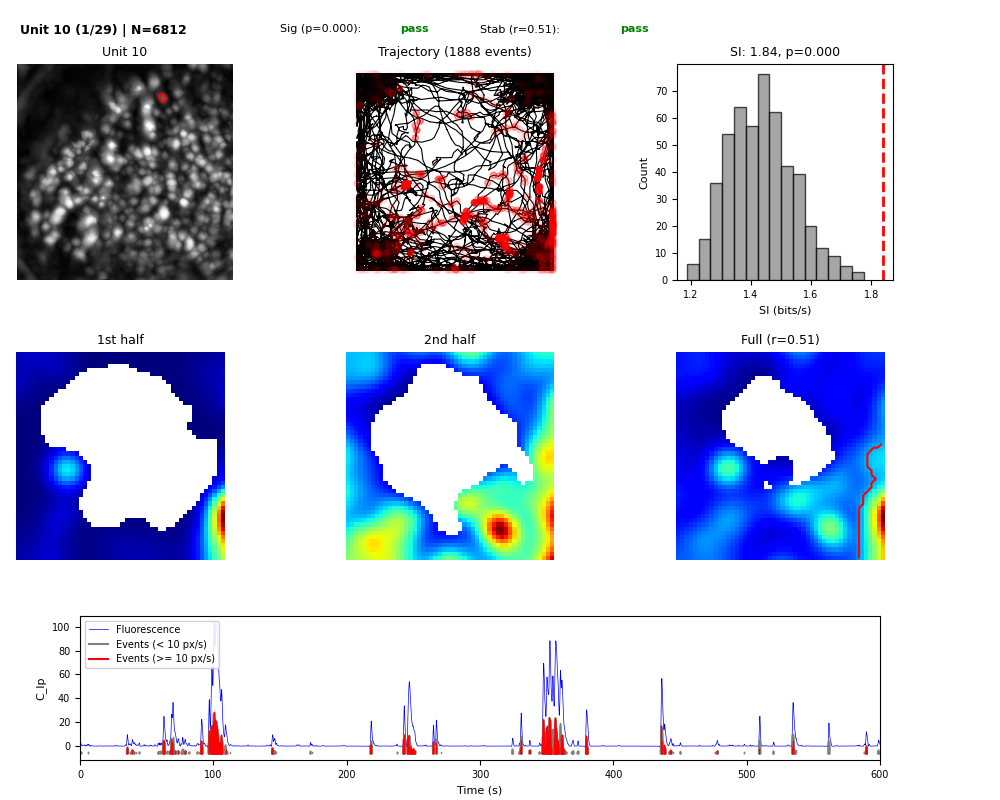

In [22]:
%matplotlib widget

# place_cell_results and _is_place_cell are defined in the coverage cell above
place_cell_units = sorted(place_cell_results.keys())
print(f"Place cells (sig + stable): {len(place_cell_units)} / {len(unit_results)}")

if len(place_cell_units) > 0:
    fig_pc, controls_pc = create_unit_browser(
        unit_results=place_cell_results,
        unique_units=place_cell_units,
        trajectory_df=trajectory_df,
        df_all_events=df_all_events,
        max_proj=max_proj,
        footprints=footprints,
        x_edges=x_edges,
        y_edges=y_edges,
        occupancy_time=occupancy_time,
        trace_name=trace_name,
        neural_fps=neural_fps,
        speed_threshold=speed_threshold,
        p_value_threshold=p_value_threshold,
        stability_threshold=stability_threshold,
        trace_time_window=trace_time_window,
        place_field_threshold=0.3,
        place_field_min_bins=place_field_min_bins,
    )
    plt.show()
    display(controls_pc)
else:
    print("No cells passed both significance and stability tests.")